In [1]:
from tqdm.notebook import tqdm

In [2]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Dlnpyutils
from dlnpyutils.utils import bspline,mad,interp

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia (E)DR3 and 2MASS photometry.
    '''
    def __init__(self,teff,logg,abund,obsphot,distance,isochrones,ext_law='CCM89',rv=3.1,
                 teff_extrap_limit=100,debug=False):
        
        '''
        Inputs:
        ------
                         teff: 2x1 array-like
                               Teff and error of star

                         logg: 2x1 array-like
                               Log(g) and error of star

                        abund: 2x2 array-like
                               first column is [M/H] and [Alpha/M] and the second 
                               column is the errors

                     obs_phot: 6x2 array-like
                               first column is BP, G, RP, J, H, and K and the second 
                               column is the errors

                     distance: float
                               distance to star in pc
                    
                   isochrones: astropy Table 
                               PARSEC isochrone table
                        
                      ext_law: string, optional
                               extinction law to use. Default is CCM89.

                               Available Extinction Laws: 
                               -------------------------

                               CCM89 - Cardelli, Clayton, & Mathis 1989
                               O94 - O'Donnell 1994
                               F99 - Fitzpatrick 1999
                               F04 - Fitzpatrick 2004
                               VCG04 - Valencic, Clayton, & Gordon 2004
                               GCC09 - Grodon, Cartledge, & Clayton 2009
                               M14 - Maiz Apellaniz et al 2014
                               F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                               D22 - Decleir et al. 2022
                        
                           rv: float, optional
                               Rv (=Av/E(B-V)) extinction law slope. Default is 3.1 
                               (required to be 3.1 if ext_law = 'F99')
                        
            teff_extrap_limit: float
                               limit for maximum allowable temperature outside 
                               isochrone range
                        
                        debug: boolean
                               print useful information to the screen

        '''
        
        # Teff and log(g)
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.logg  = logg[0] # log(g)
        self.logg_err = logg[1] # log(g) error
        
        # Salaris corrected [Fe/H]
        corrected_met = self.salaris_corrected_metallicity([abund[0,0],abund[0,1]],[abund[1,0],abund[1,1]])
        self.salfeh,self.salfeh_err = corrected_met[0],corrected_met[1]
        
        # observed photometry
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
#         if np.size(np.where(np.isfinite(test)==False))>0:
#             print('')
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.labels = ['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Extinction
        self.rv = rv
        self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K (microns)
        self.extlaw_coeff = self.extcoeff(law=ext_law)
        
        # Other
        self.debug = debug
        self.teff_extrap_limit = teff_extrap_limit 
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value.

        Inputs:
        ------
             data: array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value.

        Inputs:
        ------
              data: array-like
                    data to search through

             value: float or int
                    value of interest

        Output:     
        ------     
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    ###################
    ### Metallicity ###
    ###################
    
    def salaris_corrected_metallicity(self,metal,alpha):
        '''
        Calculate the Salaris corrected metallicity (Salaris et al. 1993) using updated solar 
        parameters from Asplund et al. 2021.
        
        Inputs:
        ------
                  metal: 2x1 array-like
                         either [Fe/H] or [M/H] with associated error
                     
                  alpha: 2x1 array-like
                         alpha abundance (either [alpha/Fe] or [alpha/M] corresponding to metal) 
                         with associate error 
                     
        Outputs:
        -------
                salfeh:  float
                         Salaris corrected metallicity
            
            salfeh_err:  float
                         error in Salaris corrected metallicity
            
        '''
        salfeh = metal[0]+np.log10(0.659*(10**alpha[0])+0.341)
        salfeh_err = np.sqrt(metal[1]**2+(10**alpha[0]/(0.517372+10**alpha[0])*alpha[1])**2)
        
        return salfeh, salfeh_err
    
    ##################
    ### Extinction ###
    ##################
    
    def extcoeff(self,rv=3.1,law='CCM89'):

        '''
        Calculate the relative extincion law coefficients for the BP, G, RP, J, H, Ks bands
        for a given Rv and extinction law.

        Input:
        -----
                    rv: float
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
                        
                   law: str
                        extinction law to use

                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022
                        
        Output:
        ------
             ext_coeff: float
                        calculated extinction coefficients for the BP, G, RP, J, H, and K bands

        '''

        leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

        # select the extinction model
        if law == 'CCM89':
            ext_model = CCM89(Rv=rv)

        elif law == 'O94':
            ext_model = O94(Rv=rv)

        elif law == 'F99':
            ext_model = F99(Rv=rv)

        elif law == 'F04':
            ext_model = F04(Rv=rv)

        elif law == 'VCG04':
            ext_model = VCG04(Rv=rv)

        elif law == 'GCC09':
            ext_model = GCC09(Rv=rv)

        elif law == 'M14':
            ext_model = M14(Rv=rv)

        elif law == 'F19':
            ext_model = F19(Rv=rv)

        elif law == 'D22':
            ext_model = D22(Rv=rv)   

        # Calculate the relative extinction coefficient
        ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))

        return ext_coeff_array
    
    def extinction(self):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and Ks bands
        
        Output:
        ------
            ext: 6x2 array
                 first column is the extinction values and the second is the errors
        '''
        
        if self.debug:
            print('### Running Aetas.extinction() ###')
            print('Inputs from Aetas.__init__()')
            print('Salaris Corrected Metallicity:',self.salfeh)
            print('Temperature:',self.teff)

        # isochrone magnitude labels
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 500 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+500.))&
                           (self.iso['logTe']>np.log10(self.teff-500.)))
        
        iso_ = self.iso[teffcut]
        
        # check to make sure there are enough isochrone points
        if np.size(np.squeeze(teffcut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
    
        # get colors and errors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        if self.debug:
            print('Calculated Observed Colors:')
            print('Observed Colors:',obs_colors)
            print('Observed Color Errors:',obs_colors_err)
        
        # create "reddening" vector (slightly modified from the normal definition)
        red_vec = np.delete(1-self.extlaw_coeff/self.extlaw_coeff[1],1)
        red_vec[0] = -1*red_vec[0]
        
        # relative extinction vector
        ext_vec = self.extlaw_coeff/self.extlaw_coeff[1]
        
        # calculate the intrinsic colors using a b-spline
        iso_colors = 999999.0*np.ones(5)
        iso_colors_deriv = 999999.0*np.ones(5)
        
        # determine if the Teff is in the isochrone range
        use_lgteff = np.log10(self.teff)
        if use_lgteff < np.min(iso_['logTe']) or use_lgteff > np.max(iso_['logTe']):
            use_lgteff = self.closest(iso_['logTe'],np.log10(self.teff))
        
        # Interpolate the color-Teff relation using a b-spline
        logTe = iso_['logTe']
        for i in range(5):
            try:
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])

                bspl = bspline(logTe,color)
                iso_colors[i] = bspl(use_lgteff)
                iso_colors_deriv[i] = bspl.derivative()(use_lgteff)
                
            except:
                try:
                    bspl = bspline(logTe,color,extrapolate=True)
                    iso_colors[i] = bspl(use_lgteff)
                    iso_colors_deriv[i] = bspl.derivative()(use_lgteff)
                
                except:
                    iso_colors[i] = 999999.0
                    iso_colors_deriv[i] = 999999.0
                    
        if self.debug:
            print('Isochrone Colors:',iso_colors)
                
        # calculate the extinctions and errors
        color_diff = obs_colors-iso_colors
        color_errs = np.abs((iso_colors_deriv*self.teff_err)/(self.teff*np.log(10)))
        color_diff_err = np.sqrt(obs_colors_err**2+color_errs**2)
        
        # find bad values this should take care of bad values from the spline
        neg_cut = np.where(color_diff>0)
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            if self.debug:
                print('All Colors are bad')
                print('Max Iso Teff:',10**np.nanmax(iso_['logTe']))
                print('Min Iso Teff:',10**np.nanmin(iso_['logTe']))
                print('Obs Teff:',self.teff)
            
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
        
        # calculate the extinction value and error
        ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        ag_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        ext = 999999.0*np.ones((6,2))
        ext[:,0] = ext_vec*ag
        ext[:,1] = ext_vec*ag_err
        
        # chisq
        iso_colors_extincted = iso_colors+red_vec*ag
        ext_chi = sum((obs_colors-iso_colors_extincted)**2/obs_colors_err**2)
        
        self.ext = ext
        
        if self.debug:
            print('A(G)+ Error:',ag,ag_err)
            print('All Extinctions:',ext[:,0])
            print('chisq:',ext_chi)
            print('resid:',obs_colors-iso_colors_extincted)
        
        return ext
    
    ##############################################
    ### Magnitudes, Extinctions, Ages & Masses ###
    ##############################################
    
    def teff_2_appmags(self,teff,age):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
                teff: float
                      Teff of star 
                      
                 age: float
                      age of star
        
        Output:
        ------
            calc_mag: 6x2 array 
                      expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        extincts = self.ext[:,0]
        
        lgage = np.log10(age*10**9)
        
        if self.debug:
            print('Running Aetas.teff_2_appmags()')
            print('Teff:',teff)
            print('Extinctions:',extincts)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            

            ### Teff check
            extrap = False

            if (10**min(iso_['logTe'])-self.teff > self.teff_extrap_limit or 
                self.teff - 10**max(iso_['logTe']) > self.teff_extrap_limit):
                if debug:
                    print('Teff Oustide extrapolation limit')
                    print('Age',age)
                    print('max iso',max(iso_['logTe']))
                    print('min iso',min(iso_['logTe']))
                    print('Teff',np.log10(self.teff))
                    print('Lower - Teff',10**min(iso_['logTe'])-self.teff)
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                extrap = True
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                
                if extrap:
                    mag_spl = interp(iso_['logTe'],iso_[self.labels[i]],lgteff,
                                     assume_sorted=False,extrapolate=True)
                else:
                    mag_spl = bspline(iso_['logTe'],iso_[self.labels[i]])
                
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
            
            ### logg spline
            if extrap:
                lgg_spl = interp(iso_['logTe'],iso_['logg'],lgteff,assume_sorted=False,extrapolate=True)
                
            else:
                lgg_spl = utils.bspline(iso_['logTe'],iso_['logg'])
            
            calc_logg = lgg_spl(lgteff)
            
            self.calc_logg = calc_logg
                
            return np.array(calc_mags, calc_logg)
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if self.debug:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            
            extrap_lo = False
            extrap_hi = False
            did_extrap = 0
            
            if (10**min(iso_lo['logTe'])-self.teff > self.teff_extrap_limit or 
                self.teff - 10**max(iso_lo['logTe']) > self.teff_extrap_limit):
            
                if self.debug:
                    print('outside iso_lo')
                    print('Age',10**lgage_lo/10**9)
                    print('max iso_lo',max(iso_lo['logTe']))
                    print('min iso_lo',min(iso_lo['logTe']))
                    print('Teff',np.log10(self.teff))
                    print('Lower - Teff',10**min(iso_lo['logTe'])-self.teff)
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            if (10**min(iso_hi['logTe'])-self.teff > self.teff_extrap_limit or 
                self.teff - 10**max(iso_hi['logTe']) > self.teff_extrap_limit):
                if self.debug:
                    print('outside iso_hi')
                    print('max iso_hi',max(iso_hi['logTe']))
                    print('min iso_hi',min(iso_hi['logTe']))
                    print('Teff',np.log10(self.teff))
                    print('Lower - Teff',10**min(iso_hi['logTe'])-self.teff)
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                extrap_lo = True
                did_extrap = 1
                
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                extrap_hi = True   
                did_extrap = 1
            
            ### use a b-spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                
                if extrap_lo:
                    mag_spl_lo = interp(iso_lo['logTe'],iso_lo[self.labels[i]],lgteff,
                                        assume_sorted=False,extrapolate=True)
                        
                else:
                    #mag_spl_lo = bspline(iso_lo['logTe'],iso_lo[self.labels[i]])(lgteff)
                    mag_spl_lo = interp(iso_lo['logTe'],iso_lo[self.labels[i]],lgteff,assume_sorted=False)
                    
                if extrap_hi:
                    mag_spl_hi = interp(iso_hi['logTe'],iso_hi[self.labels[i]],lgteff,
                                        assume_sorted=False,extrapolate=True)
                        
                else:
                    #mag_spl_hi = bspline(iso_hi['logTe'],iso_hi[self.labels[i]])(lgteff)
                    mag_spl_hi = interp(iso_hi['logTe'],iso_hi[self.labels[i]],lgteff,assume_sorted=False)
                 
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],[mag_spl_lo,mag_spl_hi],1)))
                self.age_spl_interp_deriv = age_spl_interp.deriv()
                
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
            
            ### logg spline
            if extrap_lo:
                lgg_spl_lo = interp(iso_lo['logTe'],iso_lo['logg'],lgteff,assume_sorted=False,extrapolate=True)
                
            else:
                #lgg_spl_lo = bspline(iso_lo['logTe'],iso_lo['logg'])(lgteff)
                lgg_spl_lo = interp(iso_lo['logTe'],iso_lo['logg'],lgteff,assume_sorted=False)
                
            if extrap_hi:
                lgg_spl_hi = interp(iso_hi['logTe'],iso_hi['logg'],lgteff,assume_sorted=False,extrapolate=True)
            
            else:
                #lgg_spl_hi = bspline(iso_hi['logTe'],iso_hi['logg'])(lgteff)
                lgg_spl_hi = interp(iso_hi['logTe'],iso_hi['logg'],lgteff,assume_sorted=False)
            
            lgg_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],[lgg_spl_lo,lgg_spl_hi],1)))
            
            calc_logg = lgg_spl_interp(age)
            
            self.calc_logg = calc_logg
            
            self.did_extrap = did_extrap
            
            return np.append(calc_mags, calc_logg)
        
    #######################
    ### Ages and Masses ###
    #######################
    
    def isochrone_check(self,flags=False,filename=None):
        '''
        Diagnostic to check if a star falls on isochrones or not. 
        
        Input:
        -----
               flags: boolean
                      if True return flags stating if the star falls on the isochrones.
                      prints a flag for Teff, log(g)
        
            filename: str (optional)
                      filename without extension
        '''
        
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        colorteff_labels = np.array(['BP - G','G - RP','G - J','G - H','G - Ks'])
        
        # get colors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
#         obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        ### Spectroscopic HR diagram
        plt.figure(figsize=[12,10])
        plt.scatter(10**self.iso['logTe'],self.iso['logg'],
                    c=10**self.iso['logAge']/10**9,cmap='nipy_spectral')
        plt.colorbar()
        plt.scatter(self.teff,self.logg)
        
        plt.gca().invert_xaxis()
        plt.gca().invert_yaxis()
        
        plt.xlabel(r'Teff')
        plt.ylabel(r'Log(g)')
        
        if filename != None:
            plt.savefig('{}.png'.format(filename),bbox_inches='tight')
        plt.show()
        
        ### Color Teff relationships
        fig,ax = plt.subplots(figsize=[72,10])
        
        for i in range(5):
            color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
            im = ax[i].scatter(10**self.iso['logTe'],color,c=10**self.iso['logAge']/10**9,cmap='nipy_spectral')
            ax[i].scatter(self.teff,obs_colors[i],marker='*',s=500)
            
            ax[i].set_xlabel(r'Teff')
            ax[i].set_ylabel(r'{}'.format(colorteff_labels[i]))
        
        fig.colorbar(im, ax=ax.ravel().tolist())
        
        if filename != None:
            plt.savefig('{}.png'.format(filename),bbox_inches='tight')
        plt.show()

    def get_age(self,guess_ages=np.linspace(0.012,17.)[::10]):
        '''
        Find best fitting age for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: array 
                        initial guesses for ages in Gyr

            
        Output:
        ------
                   age: float 
                        best age according to chi^2 space search
                        
                   chi: float
                        best chi^2 according to chi^2 space search
                        
                   rms: float
                        RMSE of the result
            
        '''
            
        # initialize lists
        
        curve_ages = []
        curve_chi = []
        curve_rms = []
        
        # set photometry error or 0.01 if tiny
        phot_err = np.maximum(self.phot_err,0.01)
        
        if self.debug:
            print('Running Aetas.get_age()')
            print('guess_ages:',guess_ages)

        # loop over age and ak space 
        for j in range(len(guess_ages)):
#             try:
            # calculate best fit parameters and covariance matrix
            obs_quants = np.append(np.copy(self.phot),self.logg)
            obs_quants_err = np.append(phot_err,self.logg_err)


            popt,pcov = curve_fit(self.teff_2_appmags,self.teff,obs_quants,p0=guess_ages[j],
                                  method='lm',sigma=obs_quants_err,
                                  absolute_sigma=True,maxfev=5000)

            # populate lists
            curve_ages.append(popt[0])
            curve_mags_logg = np.asarray(self.teff_2_appmags(self.teff,popt[0]))

            if self.debug:
                print('Calc App Mags + logg:',curve_mags_logg)
                print('Observed Mags + logg:',obs_quants)
                print('Observed Mags + logg Errors:',obs_quants_err)


            curve_chi.append(sum((curve_mags_logg-obs_quants)**2/obs_quants_err**2))
            curve_rms.append(np.std(curve_mags_logg-obs_quants))

#             except:
#                 # populate lists
#                 curve_ages.append(999999.0)
#                 curve_chi.append(999999.0)
#                 curve_rms.append(999999.0)
                
                
            if self.debug:
                print(j+1,guess_ages[j],curve_ages[j],curve_chi[j],curve_rms[j])
                
        if np.sum(np.array(curve_ages)<1e5)==0:
            if self.debug:
                print('All Bad')
            return 999999.0, 999999.0, 999999.0
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        age = np.asarray(curve_ages)[idx]
        chi = np.asarray(curve_chi)[idx]
        rms = np.asarray(curve_rms)[idx]
        self.age = age
        self.chi = chi
        self.rms = rms
        
        if self.debug:
            print('Best Fit Age, chi, RMS:',self.age,self.chi,self.rms)

        return age, chi, rms
    
    ##############
    ### Masses ###
    ##############
    
    def age_2_mass(self,age):
        '''
        Calculate the mass of a star from its age
        
        Input:
        -----
            age:      2x1 array
                      age of a star in Gyr and associated error

        Output:
        ------
            mass:     float 
                      mass of star in solar masses
            
            mass_err: float
                      error in the calculated mass of the star
        '''
        
        if age == 999999.0:
            return 999999.0
        
        if self.debug:
            print('Running Aetas.age_2_mass()')
            print('Age:',age)
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+500.))&
                           (self.iso['logTe']>np.log10(self.teff-500.)))
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            if self.debug:
                print('Not enough isochrone points')
            return 999999.0
        
        try:
            ### calculate the mass using a B-spline
            bspl = bspline(iso_['logAge'],iso_['Mass'])
            mass = bspl(np.log10(age*10**9))
            
        except:
            try:
                # try to extrapolate
                bspl = bspline(iso_['logAge'],iso_['Mass'],extrapolate=True)
                mass = 999999.0

            except:
                mass = 999999.0
                
        if np.isfinite(mass)==False:
            if self.debug:
                print('Nonfinite Mass')
            return 999999.0
        
        if self.debug:
            print('Mass:',mass)
        
        return mass

In [3]:
leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757])

def ccm_a(x):
    '''
    a(x) function from CCM et al. 1989

    Input:
    -----
        x: float
           effective wavelength in units of 1/micron

    Output:
    ------
        a: float
           value of the "a" function from CCM et al. 89  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a

    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
             0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a

    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a

        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a

def ccm_b(x):
    '''
    b(x) function from ccm et al. 1989

    Input:
    -----
        x: float
           effective wavelength in units of 1/micron

    Output:
    ------
        b: float
           value of the "b" function from CCM et al. 89 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b

    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
             0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b

    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b

        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b

def ccm89(wave,rv=3.1):
    '''
    Calculate the relative extinction of one band to the V band using
    Cardelli et al. 1989 (A\lambda/Av)

    Inputs:
    ------
        wave: array like
              effective wavelength in units of micron

        rv:   float
              Rv Slope of the extinction law (= Av/E(B-V)). default is 3.1

    Output:
    ------
        alav: float
              extinction relative to Av (A\lambda/Av)
    '''
    x=1/wave
    
    if np.size(x)<=1:
        return ccm_a(x)+ccm_b(x)/rv
    
    alav = 999999.0*np.ones(len(x))
    for i in range(len(x)):
        alav[i] = ccm_a(x[i])+ccm_b(x[i])/rv
        
    return alav

from scipy.interpolate import interp1d

def f99(wave):
    '''
    Calculate the relative extinction to E(B-V) using Fitzpatrick 1999 extinction law
    assuming Rv (= Av/E(B-V)) is the standard 3.1 for the Milky Way

    Input:
    -----
        wave: float
              effective wavelength in units of microns

    Output:
    ------
        alav: float
              extinction relative to Av (A\lambda/Av)
    '''
    recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])
    alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])

    x=1/wave
    spl = interp1d(recip_anchors,alebv_anchors)
    alav = spl(x)/3.1
    return alav

def sfdebv_2_ext(ebv,wave):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010 and Fitzpatrick 1999
    
    Inputs:
    ------
        ebv:  float
              Schlegel E(B-V) value
              
        wave: float
              wavelength of band to calculate extinction in mircons
        
    Output:
    ------
        ext:  float
              extinction in the band with the effective wavelength of wave
    '''
    
    micron_ext = (0.78/1.32)*ebv # Schlafly et al. 2010
    ext = f99(wave)/f99(1)*micron_ext # Fitzpatrick 1999
    return ext

import astropy.units as u
def convert_sfdebv(wave,ebv,rv=3.1):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010
    
    Inputs:
    ------
        wave: wavelength of band to calculate extinction in mircons
        ebv: Schlegel E(B-V) value
        
    Output:
    ------
        new_extinction: extinction in the band with the effective wavelength of wave
    '''
    
    micron_extinction = (0.78/1.32)*ebv
    fitz = F99(Rv=rv)
    return fitz(1/(wave*u.micron))/fitz(1*u.micron)*micron_extinction

import astropy.units as u
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

def extcoeff(wavelength,rv=3.1,law='CCM89',ref='G'):

    '''
    Calculate the relative extincion law coefficients for a given wavelength relative to the 
    BP, G, RP, J, H, K or user defined band

    Input:
    -----
        wavelength: float
                    Effective wavelength of band of interest in microns
        
        law:        str
                    extinction law to use
                         
                    Available Extinction Laws: 
                    -------------------------
                        
                    CCM89 - Cardelli, Clayton, & Mathis 1989
                    O94 - O'Donnell 1994
                    F99 - Fitzpatrick 1999
                    F04 - Fitzpatrick 2004
                    VCG04 - Valencic, Clayton, & Gordon 2004
                    GCC09 - Grodon, Cartledge, & Clayton 2009
                    M14 - Maiz Apellaniz et al 2014
                    F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                    D22 - Decleir et al. 2022

        rv:         float
                    Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
        ref:        str or float
                    reference filter. Can be 'BP', 'G', 'RP', 'J', 'H', 'K' 
                    or user defined float that is the wavelength in microns of the band

    Output:
    ------
        ext_coeff:  float
                    calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                    relative to the Gaia G band

    '''

    leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
    
    # select the extinction model
    if law == 'CCM89':
        ext_model = CCM89(Rv=rv)

    elif law == 'O94':
        ext_model = O94(Rv=rv)

    elif law == 'F99':
        ext_model = F99(Rv=rv)

    elif law == 'F04':
        ext_model = F04(Rv=rv)

    elif law == 'VCG04':
        ext_model = VCG04(Rv=rv)

    elif law == 'GCC09':
        ext_model = GCC09(Rv=rv)

    elif law == 'M14':
        ext_model = M14(Rv=rv)

    elif law == 'F19':
        ext_model = F19(Rv=rv)

    elif law == 'D22':
        ext_model = D22(Rv=rv)   

    # Calculate the relative extinction coefficient
    if type(ref) == str:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(leff[ref]*u.micron)
    
    elif type(ref) == float:
        ext_coeff = ext_model(wavelength*u.micron)/ext_model(ref*u.micron)
    
    return ext_coeff

### Geometry

import MagellanicStream as MagellanicStream

def LMCdisk_cart(ra, dec):
    
    '''
    Calculate the position of stars in the LMC disk plane with 
    center at the LMC center in cartesian coordinates (x, y).
    This also calculates the distance to the individual stars.
    
    This follows van der Marel and Cioni 2001 with parameters from Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Input
    - ra: right ascension of stars
    - dec: declination of stars
    
    Output
    - x_m: x coordinate
    - y_m: y coordinate
    - dis: distance to LMC star
    '''
    alph0 = np.radians(82.25) #right ascension of center of LMC
    delt0 = np.radians(-69.50) #declination of center of LMC
    pa = np.radians(149.23+90.00) #146.37 #position angle of line of nodes
    io = np.radians(25.86) #27.81 #inclination of LMC disk
    d0 = 49.90 #distance to center of LMC
    
    #convert to radians
    ra = np.radians(ra)
    dec = np.radians(dec)
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    
    cr = cd*np.cos(dec)*np.cos(ra-alph0)+sd*np.sin(dec)
    srcp = -np.cos(dec)*np.sin(ra-alph0)
    srsp = cd*np.sin(dec) - sd*np.cos(dec)*np.cos(ra-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cr - np.sin(io)*np.cos(pa)*srsp + np.sin(io)*np.sin(pa)*srcp)
    
    x_m = dis*srcp
    y_m = dis*(np.cos(io)*srsp + np.sin(io)*cr) - d0*np.sin(io)
    
    return x_m, y_m, dis

def elliptical_radius(x,y):
    '''
    Calculate elliptical radius from cartesian(x,y) using equation 6 form Choi et al. 2018 (SMASHing the LMC: 
    Mapping a Ring-like Stellar Overdensity in the LMC Disk)
    
    Parameters:
    ----------
        x: x cartesian coordinate
        y: y cartesian coordinate
        psi: semimajor axis position angle
    Returns:
    -------
        ell_r: elliptical radius
    '''
    
    
    b_a = 0.836 # disk axis ratio
    psi = 227.24 + 90 # position angle of semi major axis
    cpsi = np.cos(np.radians(psi)) 
    spsi = np.cos(np.radians(psi))
    
    ell_r = np.sqrt(np.square(x*cpsi-y*spsi) + np.square(b_a*(x*spsi + y*cpsi)))
    
    return ell_r

# PARSEC 

In [4]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive = massive[np.argsort(massive['logAge'])]
massive = massive['MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']

# APOGEE LMC

In [5]:
lmcdr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17rev1_qacuts.fits.gz')

apoafe = lmcdr17['ALPHA_M']+lmcdr17['M_H']-lmcdr17['FE_H']
apoafe_err = np.sqrt(lmcdr17['ALPHA_M_ERR']**2+lmcdr17['M_H_ERR']**2+lmcdr17['FE_H']**2)

salfeh = lmcdr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(lmcdr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe))+0.341))*apoafe_err)**2)

diane = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/output_LMC_DR16_all.fits.gz')

_, diane_idx, me_idx = np.intersect1d(diane['APOGEE_ID'],lmcdr17['APOGEE_ID'], return_indices=True)

In [6]:
from dlnpyutils import coords
import astropy.units as u
from astropy.coordinates import SkyCoord

lmcx, lmcy, lmcdis = LMCdisk_cart(lmcdr17['RA'], lmcdr17['DEC'])
lmcr = elliptical_radius(lmcx,lmcy)

### lmcdr17
gc = SkyCoord(ra=lmcdr17['RA']*u.degree, dec=lmcdr17['DEC']*u.degree, frame='icrs')
lms_lmc,bms_lmc = coords.gal2mag(gc.galactic.l.value,gc.galactic.b.value)

for i in range(len(lms_lmc)):
    if lms_lmc[i] > 180.:
        lms_lmc[i] = lms_lmc[i]-360

In [7]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

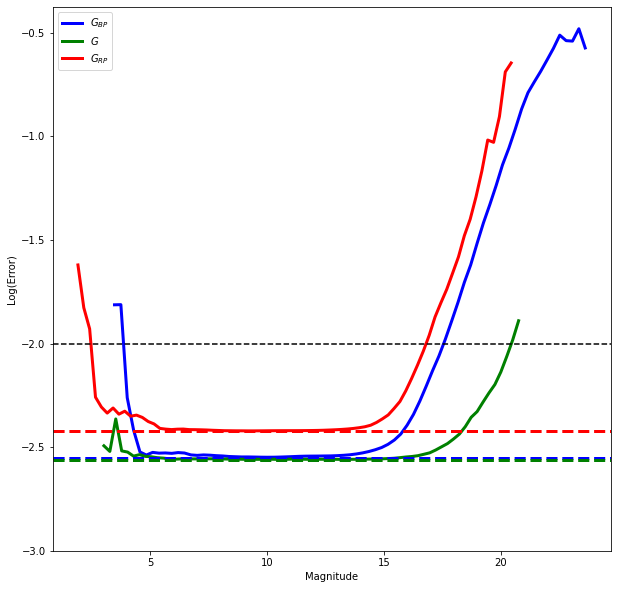

In [8]:
from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Fit the errors
bp_fin = np.where(np.isfinite(bpbin)==True)
g_fin = np.where(np.isfinite(gbin)==True)
rp_fin = np.where(np.isfinite(rpbin)==True)

bperrfunc = bspline(np.arange(bpmin,bpmax,bpdiff/binnum)[bp_fin],bpbin[bp_fin])
gerrfunc = bspline(np.arange(gmin,gmax,gdiff/binnum)[g_fin],gbin[g_fin])
rperrfunc = bspline(np.arange(rpmin,rpmax,rpdiff/binnum)[rp_fin],rpbin[rp_fin])

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.axhline(np.log10(0.0027901700),lw=3.0,c='blue',ls='--')
plt.axhline(np.log10(0.0027553202),lw=3.0,c='green',ls='--')
plt.axhline(np.log10(0.0037793818),lw=3.0,c='red',ls='--')
plt.axhline(np.log10(0.01),c='k',ls='--')
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

In [9]:
allStar = Table(fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz'))
allStar = allStar['APOGEE_ID','FE_H','FE_H_ERR','J','H','K','J_ERR','H_ERR','K_ERR']

<ipython-input-10-a3225ab1c2e3>:24: RuntimeWarning: divide by zero encountered in log10
  hmaherr = np.log10(allStar['H_ERR'][h_fin])


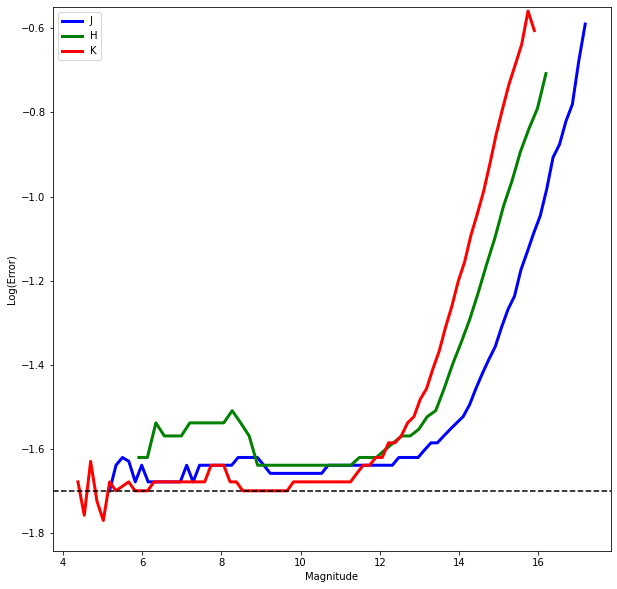

In [10]:
binnum = 75

### J
j_fin = np.where((np.isfinite(allStar['J'])==True)&(allStar['J']<50.)&
                 (np.isfinite(allStar['J_ERR'])==True)&(allStar['J_ERR']<1.))

jmin = min(allStar['J'][j_fin])
jmax = max(allStar['J'][j_fin])

jdiff = jmax-jmin
jmaherr = np.log10(allStar['J_ERR'][j_fin])

jbin ,_,_ = binned_statistic(allStar['J'][j_fin],jmaherr,'median',bins=binnum)
jerrfunc = bspline(np.arange(jmin,jmax,jdiff/binnum),jbin)

### H
h_fin = np.where((np.isfinite(allStar['H'])==True)&(allStar['H']<50.)&
                 (np.isfinite(allStar['H_ERR'])==True)&(allStar['H_ERR']<1.))

hmin = min(allStar['H'][h_fin])
hmax = max(allStar['H'][h_fin])

hdiff = hmax-hmin
hmaherr = np.log10(allStar['H_ERR'][h_fin])

hbin ,_,_ = binned_statistic(allStar['H'][h_fin],hmaherr,'median',bins=binnum)
herrfunc = bspline(np.arange(hmin,hmax,hdiff/binnum),hbin)

### K
k_fin = np.where((np.isfinite(allStar['K'])==True)&(allStar['K']<50.)&
                 (np.isfinite(allStar['K_ERR'])==True)&(allStar['K_ERR']<1.))

kmin = min(allStar['K'][k_fin])
kmax = max(allStar['K'][k_fin])

kdiff = kmax-kmin
kmaherr = np.log10(allStar['K_ERR'][k_fin])

kbin ,_,_ = binned_statistic(allStar['K'][k_fin],kmaherr,'median',bins=binnum)
kerrfunc = bspline(np.arange(kmin,kmax,kdiff/binnum),kbin)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(jmin,jmax,jdiff/binnum),jbin,lw=3.0,c='blue',label=r'J')
plt.plot(np.arange(hmin,hmax,hdiff/binnum),hbin,lw=3.0,c='green',label=r'H')
plt.plot(np.arange(kmin,kmax,kdiff/binnum),kbin,lw=3.0,c='red',label=r'K')
plt.legend()
plt.axhline(np.log10(0.02),c='k',ls='--')
plt.ylim(top=-0.55)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/2masserrorcurve.pdf',dpi=300,bbox_inches='tight');

### Calculate Errors for NaNs
jerr = 999999.0*np.ones(len(lmcdr17))
herr = 999999.0*np.ones(len(lmcdr17))
kerr = 999999.0*np.ones(len(lmcdr17))

for i in range(len(lmcdr17)):
    if np.isfinite(lmcdr17['J_ERR'][i])==False:
        jerr[i] = 10**jerrfunc(lmcdr17['J'][i])
    else:
        jerr[i] = lmcdr17['J_ERR'][i]
        
    if np.isfinite(lmcdr17['H_ERR'][i])==False:
        herr[i] = 10**herrfunc(lmcdr17['H'][i])
    else:
        herr[i] = lmcdr17['H_ERR'][i]
        
    if np.isfinite(lmcdr17['K_ERR'][i])==False:
        kerr[i] = 10**kerrfunc(lmcdr17['K'][i])
    else:
        kerr[i] = lmcdr17['K_ERR'][i]
        
### Replace nan's with zeropoint error
jerr = np.nan_to_num(jerr,nan=0.02)
herr = np.nan_to_num(herr,nan=0.02)
kerr = np.nan_to_num(kerr,nan=0.02)

In [11]:
from scipy.interpolate import BSpline


teff_tck = (np.array([3527.46704102, 3527.46704102, 3527.46704102, 3527.46704102, 3708.91847923, 3890.36991744, 
                      4071.82144442, 4253.27263849, 4434.72434304, 4616.17578125, 4797.62695312, 4979.07848011,
                      5160.53018466, 5341.98144531, 5523.43261719, 5523.43261719, 5523.43261719, 5523.43261719]),
            np.array([ -36.38271977,  -43.37201334,  -17.08585409,   67.8896712 , 69.84606503,  100.46933976,  
                      103.94758719,   75.90855137,60.21227975,   -5.14343676,   -6.42134699,  217.36965544,
                      -447.26168354, -197.7697192 ,    0.        ,    0.        , 0.        ,    0.        ]),3)


tcorr_spl = BSpline(teff_tck[0],teff_tck[1],teff_tck[2])

tcorr = tcorr_spl(lmcdr17['FPARAM'][:,0])+lmcdr17['FPARAM'][:,0]

mh_tck = (np.array([-2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -1.96716837e+00,
                    -1.71575650e+00, -1.46434463e+00, -1.21293276e+00, -9.61520889e-01, -7.10109077e-01,
                    -4.58697175e-01, -2.07285313e-01, 4.41265486e-02, 2.95538409e-01, 5.46950281e-01, 
                    5.46950281e-01, 5.46950281e-01, 5.46950281e-01]),
          np.array([1.12848696e+02, 1.00546777e+02, 1.15992357e+02, 9.79509398e+01, 3.87315323e+01, 
                    1.86357031e+01, -1.50821811e+01, 1.21509274e+01, 6.69424869e+00, -2.90025110e+00,
                    -2.68067104e+01, -3.13392475e+01, -8.25826363e+01,-6.49082047e+01, 0.00000000e+00, 
                    0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),3)

teff_cal = BSpline(mh_tck[0],mh_tck[1],mh_tck[2])(lmcdr17['FPARAM'][:,3])+tcorr

# Calculation

In [12]:
# lite = np.arange(len(lmcdr17))[::12]

lmc_ext = 999999.0*np.ones((len(lmcdr17),6))
lmc_ext_err = 999999.0*np.ones((len(lmcdr17),6))
# lmc_age = 999999.0*np.ones(len(lmcdr17))
# lmc_chi = 999999.0*np.ones(len(lmcdr17))
# lmc_rms = 999999.0*np.ones(len(lmcdr17))
# lmc_mass = 999999.0*np.ones(len(lmcdr17))

for i in tqdm(range(len(lmcdr17))):
    
    # Initialize Aetas 
    te = np.array([teff_cal[i],lmcdr17['TEFF_ERR'][i]])
    
    lg = np.array([lmcdr17['LOGG'][i],lmcdr17['LOGG_ERR'][i]])
    
    ab = np.array([[lmcdr17['FE_H'][i],apoafe[i]],
                   [lmcdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    
    op = np.array([[lmcdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    lmcdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    lmcdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    lmcdr17['J'][i],lmcdr17['H'][i],lmcdr17['K'][i]],
                   [bperr[i],gerr[i],rperr[i],jerr[i],
                    herr[i],kerr[i]]]).T
    
    di = lmcdis[i]*1000

    CalcAge = Aetas(te,lg,ab,op,di,massive,teff_extrap_limit=200)
    
    exts = CalcAge.extinction()
    lmc_ext[i,:],lmc_ext_err[i,:] = exts[:,0],exts[:,1]
#     lmc_age[i],lmc_chi[i],lmc_rms[i] = CalcAge.get_age()
#     lmc_mass[i] = CalcAge.age_2_mass(lmc_age[i])

  0%|          | 0/6130 [00:00<?, ?it/s]

In [13]:
iso.columns

NameError: name 'iso' is not defined

In [ ]:
import ages as ages

iso = Table.read('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')

iso['GEDR3mag'].name = 'Gmag'
iso['G_BPEDR3mag'].name = 'G_BPmag'
iso['G_RPEDR3mag'].name = 'G_RPmag'

tab = Table.read('lmc_extra_dr17.fits')
out = ages.age(tab,iso)

In [ ]:
plt.figure(figsize=[12,7])
plt.hist(out['agemyr']/1000,bins=500)
plt.xlabel(r'Age');

In [ ]:
plt.figure(figsize=[12,7])
plt.scatter(out['agemyr']/1000,out['feh'],s=10)
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]');

In [ ]:
plt.figure(figsize=[12,10])
plt.scatter(tab['J']-tab['K'],tab['K'],c=out['agemyr']/1000,cmap='nipy_spectral',s=10)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'J - Ks')
plt.ylabel(r'Ks');

In [ ]:
np.where(out['agemyr']==np.min(out['agemyr']))

In [ ]:
plt.figure(figsize=[14,7])
plt.scatter(tab['FE_H'],tab['ALPHA_FE'],c=out['agemyr']/1000,cmap='nipy_spectral',s=10)
plt.colorbar()
plt.ylim(-0.4,0.4)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]');

In [ ]:
iso2 = iso[np.where((iso['label']==3)|(iso['label']==7))]

out2 = ages.age(tab,iso2)

In [ ]:
plt.figure(figsize=[12,7])
plt.hist(out2['agemyr']/1000,bins=50)
plt.xlabel(r'Age');

In [ ]:
plt.scatter(out2['agemyr'],tab['EXT'][:,1],s=10)
plt.ylim(0,0.75)

In [ ]:
old, = np.where(out2['agemyr']/1000>10.5)
len(old)

In [ ]:
plt.figure(figsize=[12,7])
plt.scatter(out2['agemyr']/1000,out2['feh'],s=10)
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]');

In [ ]:
plt.figure(figsize=[12,10])
plt.scatter(tab['J']-tab['K'],tab['K'],c=out2['agemyr']/1000,cmap='nipy_spectral',s=10)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'Color as Age')
plt.xlabel(r'J - Ks')
plt.ylabel(r'Ks');

In [ ]:
np.where(out['agemyr']==np.min(out['agemyr']))

In [ ]:
tab.columns

In [ ]:
plt.figure(figsize=[14,7])
plt.scatter(tab['FE_H'],tab['ALPHA_FE'],c=out2['agemyr']/1000,cmap='nipy_spectral',s=10)
plt.colorbar()
plt.ylim(-0.4,0.4)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]');

In [ ]:
plt.figure(figsize=[12,7])
plt.scatter(out['agemyr'],out2['agemyr']-out['agemyr'],c=tab['FE_H'],s=10,cmap='nipy_spectral')
plt.colorbar()

In [ ]:
plt.figure(figsize=[12,7])
plt.scatter(tab['FE_H'],out2['agemyr']-out['agemyr'],s=10)
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'label 3,7 - All Age')
plt.savefig('davidsmethod_resid.png',bbox_inches='tight');

In [ ]:
plt.figure(figsize=[12,7])
plt.hist(out['agemyr']/1000,bins=50,histtype='step',lw=3.0,label='All')
plt.hist(out2['agemyr']/1000,bins=50,histtype='step',lw=3.0,label='3,7')
plt.legend()
plt.xlabel(r'Age')
plt.savefig('davidsmethod_hist.png',bbox_inches='tight');

In [ ]:
plt.figure(figsize=[12,10])
plt.subplot(211)
plt.scatter(out['agemyr']/1000,out2['feh'],s=10)
plt.title(r'All')
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
plt.subplot(212)
plt.scatter(out2['agemyr']/1000,out2['feh'],s=10)
plt.title(r'3,7')
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
plt.savefig('davidsmethod_AMR.png',bbox_inches='tight');

In [ ]:
plt.figure(figsize=[24,10])
plt.subplot(121)
plt.scatter(tab['J']-tab['K'],tab['K'],c=out['agemyr']/1000,cmap='nipy_spectral',s=10)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'All; Color as Age')
plt.xlabel(r'J - Ks')
plt.ylabel(r'Ks')
plt.subplot(122)
plt.scatter(tab['J']-tab['K'],tab['K'],c=out2['agemyr']/1000,cmap='nipy_spectral',s=10)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'3,7; Color as Age')
plt.xlabel(r'J - Ks')
plt.ylabel(r'Ks')
plt.savefig('davidsmethod_2MASSCMD.png',bbox_inches='tight');

In [ ]:
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.scatter(tab['FE_H'],tab['ALPHA_FE'],c=out['agemyr']/1000,cmap='nipy_spectral',s=10)
plt.colorbar()
plt.ylim(-0.4,0.4)
plt.title(r'All')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')

plt.subplot(212)
plt.scatter(tab['FE_H'],tab['ALPHA_FE'],c=out2['agemyr']/1000,cmap='nipy_spectral',s=10)
plt.colorbar()
plt.ylim(-0.4,0.4)
plt.title(r'3,7')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')
plt.savefig('davidsmethod_chem.png',bbox_inches='tight');

In [ ]:
iso_lab3 = iso[np.where(iso['label']==3)]

out_lab3 = ages.age(tab,iso_lab3)

In [ ]:
iso_lab7 = iso[np.where(iso['label']==7)]

out_lab7 = ages.age(tab,iso_lab7)

In [ ]:
out_lab3['chisq']

In [ ]:
lower3chi, = np.where(out_lab3['chisq']<out_lab7['chisq'])
lower7chi, = np.where(out_lab3['chisq']>out_lab7['chisq'])

print(len(lower3chi))
print(len(lower7chi))

In [ ]:
plt.figure(figsize=[10,10])
plt.scatter((tab['J']-tab['K'])[lower3chi],tab['K'][lower3chi],s=10)
plt.scatter(tab['J']-tab['K'],tab['K'],s=10,zorder=0)
plt.gca().invert_yaxis()
plt.title(r'3; Color as Age')
plt.xlabel(r'J - Ks')
plt.ylabel(r'Ks')

In [ ]:
plt.figure(figsize=[12,7])
plt.hist(out_lab3['agemyr']/1000,bins=50,histtype='step',lw=3.0,label='3')
plt.hist(out_lab7['agemyr']/1000,bins=50,histtype='step',lw=3.0,label='7')
plt.legend()
plt.xlabel(r'Age')
plt.savefig('davidsmethod_hist37.png',bbox_inches='tight');

In [ ]:
plt.figure(figsize=[12,10])
plt.subplot(211)
plt.scatter(out_lab3['agemyr']/1000,out_lab3['feh'],s=10)
plt.title(r'3')
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
plt.subplot(212)
plt.scatter(out_lab7['agemyr']/1000,out_lab7['feh'],s=10)
plt.title(r'7')
plt.xlabel(r'Age')
plt.ylabel(r'[Fe/H]')
plt.savefig('davidsmethod_AMR37.png',bbox_inches='tight');

In [ ]:
plt.figure(figsize=[24,10])
plt.subplot(121)
plt.scatter(tab['J']-tab['K'],tab['K'],c=out_lab3['agemyr']/1000,cmap='nipy_spectral',s=10)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'3; Color as Age')
plt.xlabel(r'J - Ks')
plt.ylabel(r'Ks')
plt.subplot(122)
plt.scatter(tab['J']-tab['K'],tab['K'],c=out_lab7['agemyr']/1000,cmap='nipy_spectral',s=10)
plt.colorbar()
plt.gca().invert_yaxis()
plt.title(r'7; Color as Age')
plt.xlabel(r'J - Ks')
plt.ylabel(r'Ks')
plt.savefig('davidsmethod_2MASSCMD37.png',bbox_inches='tight');

In [ ]:
plt.figure(figsize=[10,10])
plt.scatter(out_lab3['agemyr']/1000,out_lab7['agemyr']/1000)
plt.plot([0,17.5],[0,17.5],c='k',lw=3.)
plt.xlabel(r'Label 3 Age')
plt.ylabel(r'Label 7 Age')
plt.savefig('davidsmethod_age2age37.png',bbox_inches='tight');

In [ ]:
np.asarray(iso2['mh'])+2.

In [ ]:
type(iso[0])

In [ ]:
type(np.array([]))

In [ ]:
test = Table(names=('ext','ext_err','phot','logg','age','age_chi','age_rms','mass'))

In [105]:
test['ext'] = 999999.0*np.ones(6)

ValueError: could not broadcast input array from shape (6,) into shape (0,)